In [76]:
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from IPython.display import display, HTML
# supress scientific notation
np.set_printoptions(suppress=True)

from sklearn.cluster import KMeans

#import my modules
import acquire as a
import prepare as p
import wrangle_zillow as w
import explore as ex

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# Acquire

In [ ]:
df = a.get_zillow()

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
#getting the latest transactions 
df = df.sort_values(by ='transactiondate', ascending=True).drop_duplicates( subset = 'parcelid' ,keep= 'last')
  

In [ ]:
df.shape

In [ ]:
#this list has all types of single unit properties
single= ['Single Family Residential',' Mobile Home' , 'Townhouse ', 'Manufactured, Modular, Prefabricated Homes'  ]

In [ ]:
#create a mask
single_mask = df['propertylandusedesc'].isin(single)

In [ ]:
#if unitcnt == that's means is is a single property but if it is null we can compare with our list of single

In [ ]:
#using that mask and also add  a condition
df_single = df[single_mask & ((df['unitcnt'] == 1) | (df['unitcnt'].isnull()))]
    

In [ ]:
#this df contains all single unit homes of 2017 with the latest transaction
df_single.shape

In [ ]:
a.summarize(df_single)

**takeaways**
- numberofstories there is one property with 6 stories , I would drop it!
- unitcnt is not needed any more. I would drop it
- there are a lot of nulls so in preparation step I will handle them

# Preparation

In [ ]:
p.miss_dup_values(df_single)

In [ ]:
df_single.shape

In [ ]:
# I will drop columns and rows with a lot of null values 
#here I will include unitcnt because the value is 1 for all the properties . as it is the next to 65.6% 
#I can include it in my function
df_single= p.handle_missing_values(df_single, prop_required_columns=0.75, prop_required_row=0.75)

In [ ]:
df_single.shape

In [ ]:
p.miss_dup_values(df_single)

In [ ]:

#all these  columns represent a minimun amount so I can drop them 
df_single= p.drop_low_missing_values(df_single, per= 3 )

In [ ]:
df_single.shape

In [ ]:
p.miss_dup_values(df_single)

In [ ]:
a.summarize(df_single)

In [ ]:
p.distribution(df_single)

### get county names and create dummy variables with those

In [ ]:
# create dummy vars of fips id
county_df = pd.get_dummies(df_single.fips)

In [ ]:
county_df.head()

- county # 6037 -----> Los Angeles
- county # 6059 -----> Orange
- county # 6111 -----> Ventura

In [ ]:
#df_single = p.get_counties(df_single)

In [ ]:
# print("LA County Verified: ", df_single[df_single.fips==6037]['fips'].count() == df_single.los_angeles.sum())
# print("Orange County Verified: ", df_single[df_single.fips==6059]['fips'].count() == df_single.orange.sum())
# print("Ventura County Verified: ", df_single[df_single.fips==6111]['fips'].count() == df_single.ventura.sum())

In [ ]:
#now in my function I can drop fips

###  Compute new features out of existing features in order to reduce noise, capture signals, and reduce collinearity, or dependence between independent variables.

**- age**

In [ ]:
df_single['age'] = 2017 - df.yearbuilt

In [ ]:
df_single.head()

In [ ]:
df_single[['age']].describe()

In [ ]:
# I can drop yearbuilt

**- taxrate**


In [ ]:
df_single['taxrate'] = df_single.taxamount/df_single.taxvaluedollarcnt*100

In [ ]:
df_single[['taxrate']].describe()

In [ ]:
# I will drop taxamount and taxvaluedollarcnt

**- transactiondate**


In [ ]:
df_single[['transactiondate']].head()

In [ ]:
#I decided to convert transaction date to int so in the future can make groups

In [ ]:
df_single['transactiondate']=(df_single['transactiondate'].str.replace(' ','').str.replace('-',''))

In [ ]:
df_single['transactiondate'] = df_single['transactiondate'].astype('int')

In [ ]:
#df_single[(df_single.transactiondate >= 20170101) &  (df_single.transactiondate < 20170501)]

In [ ]:
#try to bin transaction date
df_single['quadrimester'] = pd.cut(df_single.transactiondate, bins = [ 20170100, 20170500, 20170900, 20171230])

In [ ]:
df_single['quadrimester'].value_counts()

In [ ]:
#this is just to check if bins are correct
#this is the fist quadrimester
(df_single['transactiondate']<20170501).sum()

In [ ]:
#this is the second quadrimester
((df_single['transactiondate']>= 20170501)  & (df_single['transactiondate']<20170901)).sum()

In [ ]:
#this is the third quadrimester
((df_single['transactiondate']>= 20170901)  & (df_single['transactiondate']<20171232)).sum()

In [ ]:
#try to bin transaction date
df_single['quadrimester'] = pd.cut(df_single.transactiondate, bins = [ 20170100, 20170500, 20170900, 20171230],
                                 labels = [1,2,3])

In [ ]:
df_single['quadrimester'].value_counts()

In [ ]:
df_single[['transactiondate', 'quadrimester']].sample(30)

In [ ]:
df_single.info()

In [ ]:
df_single['lotsize_acres'] = df_single.lotsizesquarefeet/43560
df_single = df_single.drop(columns = ['yearbuilt', 'taxamount', 'taxvaluedollarcnt', 'lotsizesquarefeet'  ])

In [ ]:
def create_features (df) :
    '''
    takes in a df and create age , taxrate, lotsize_acres columns and convert transactiondate to int
    drops 'yearbuilt', 'taxamount', 'taxvaluedollarcnt', lotsizesquarefeet columns
    '''
    #create a new colum with age
    df['age'] = 2017 - df.yearbuilt
    
    #taxrate
    df['taxrate'] = df.taxamount/df.taxvaluedollarcnt*100
    
  #transactiondate
    df['transactiondate']=(df['transactiondate'].str.replace(' ','').str.replace('-',''))
    df['transactiondate'] = df['transactiondate'].astype('int')
    #try to bin transaction date
    df['quadrimester'] = pd.cut(df.transactiondate, bins = [ 20170100, 20170500, 20170900, 20171230],
                                 labels = [1,2,3])
     # create acres variable
    df['lotsize_acres'] = df.lotsizesquarefeet/43560
    
    #drop columns
    df = df.drop(columns = ['yearbuilt', 'taxamount', 'taxvaluedollarcnt', 'lotsizesquarefeet'  ])
    
    return df

In [ ]:
df_single.columns

In [ ]:
# I will handle outliers for : 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'regionidzip', 
#'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxrate', 'lotsize_acres', 'age'

In [ ]:
df_single.head()

In [ ]:
col = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'regionidzip', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxrate', 'lotsize_acres', 'age']

In [ ]:
df_final= p.remove_outliers(df_single, col)

In [ ]:
df_final.describe().T


In [ ]:
df_final.lotsize_acres.describe()

In [ ]:
p.distribution_boxplot(df_final)

In [ ]:
df_final.shape, df_single.shape

In [ ]:
df_final['regionidcity'].value_counts()

In [ ]:
df_final.info()

In [ ]:
# here I can drop
# propertylandusedesc 

In [106]:
#checking wrangle_zillow function
train, validate, test= w.wrangle_zillow()

before outliers (50819, 24)
df shape --> (34126, 23)
train -> (19110, 23)
validate -> (8190, 23)
test -> (6826, 23)


In [107]:
((50819-34126)*100) / 50819

32.847950569668825

In [108]:
X_train, y_train, X_validate, y_validate, X_test, y_test = p.split_Xy(train, validate, test, 'logerror') 

X_train -> (19110, 22)               y_train->(19110,)
X_validate -> (8190, 22)         y_validate->(8190,) 
X_test -> (6826, 22)                  y_test>(6826,)


In [109]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19110 entries, 54155 to 12794
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   parcelid                      19110 non-null  object  
 1   bathroomcnt                   19110 non-null  float64 
 2   bedroomcnt                    19110 non-null  float64 
 3   calculatedfinishedsquarefeet  19110 non-null  float64 
 4   latitude                      19110 non-null  float64 
 5   longitude                     19110 non-null  float64 
 6   propertylandusetypeid         19110 non-null  float64 
 7   regionidcity                  19110 non-null  float64 
 8   regionidcounty                19110 non-null  float64 
 9   regionidzip                   19110 non-null  float64 
 10  structuretaxvaluedollarcnt    19110 non-null  float64 
 11  landtaxvaluedollarcnt         19110 non-null  float64 
 12  transactiondate               19110 non-nu

In [110]:
train.head()

parcelid  bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  \
54155  10820004          2.0         3.0                        1433.0   
44501  14204400          3.0         3.0                        3126.0   
77435  11468343          1.0         2.0                         806.0   
43382  13934312          2.0         4.0                        1806.0   
34022  12837858          2.0         3.0                        1851.0   

         latitude    longitude  propertylandusetypeid  regionidcity  \
54155  34209445.0 -118505975.0                  261.0       12447.0   
44501  33860307.0 -117732319.0                  261.0       16764.0   
77435  33957244.0 -118391943.0                  261.0       12447.0   
43382  33790993.0 -117926578.0                  261.0       24832.0   
34022  34031627.0 -117917417.0                  261.0      118694.0   

       regionidcounty  regionidzip  ...  transactiondate  county_name  \
54155          3101.0      96415.0  ...         20170705  Los Angeles   
44501          1286.0      97027.0  ...         20170608       Orange   
77435          3101.0      96026.0  ...         20170919  Los Angeles   
43382          1286.0      97047.0  ...         20170605       Orange   
34022          3101.0      96488.0  ...         20170508  Los Angeles   

       la_cnty orange_cnty ventura_cnty   age   taxrate  quadrimester  \
54155        1           0            0  67.0  1.208093             2   
44501        0           1            0  25.0  1.063828             2   
77435        1           0            0  75.0  1.215730             3   
43382        0           1            0  64.0  1.461827             2   
34022        1           0            0  59.0  1.285648             2   

       lotsize_acres  logerror_bins  
54155       0.182484  (-0.05, 0.05]  
44501       0.151515  (-0.05, 0.05]  
77435       0.135560    (0.05, 0.2]  
43382       0.167126  (-0.05, 0.05]  
34022       0.153926  (-0.05, 0.05]  

[5 rows x 23 columns]

In [111]:
scal_var = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet','latitude', 'longitude', 
            'structuretaxvaluedollarcnt', 'age', 'taxrate', 'lotsize_acres']

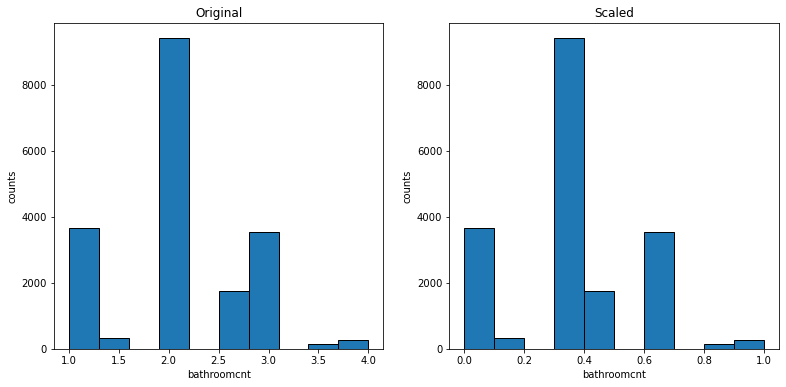

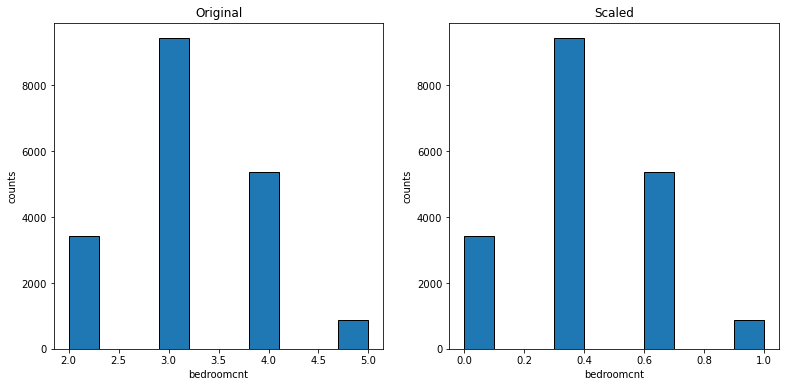

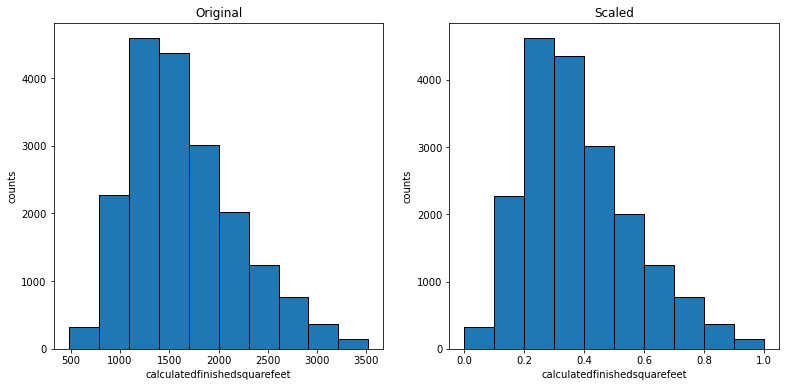

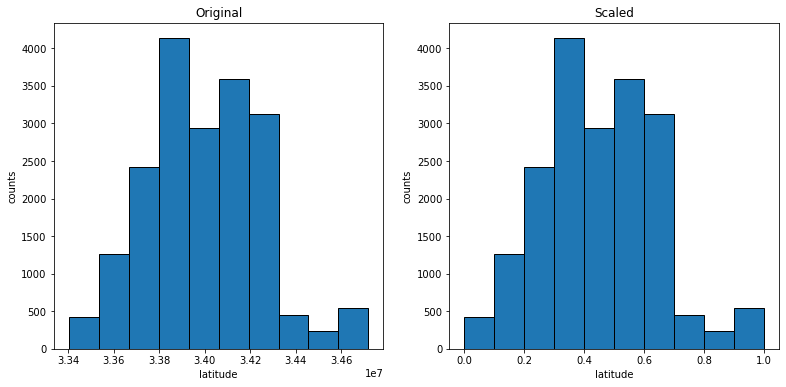

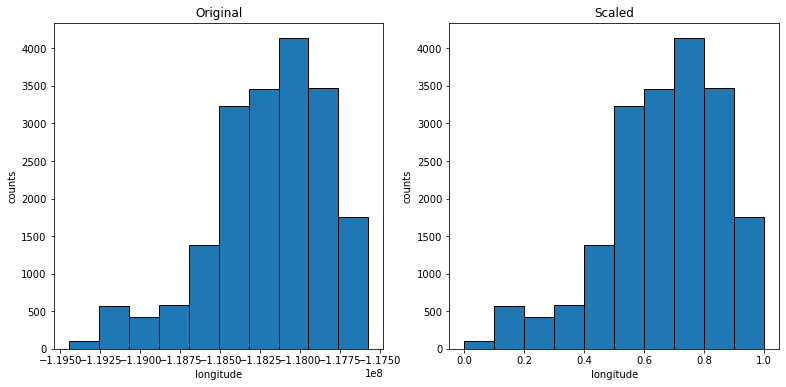

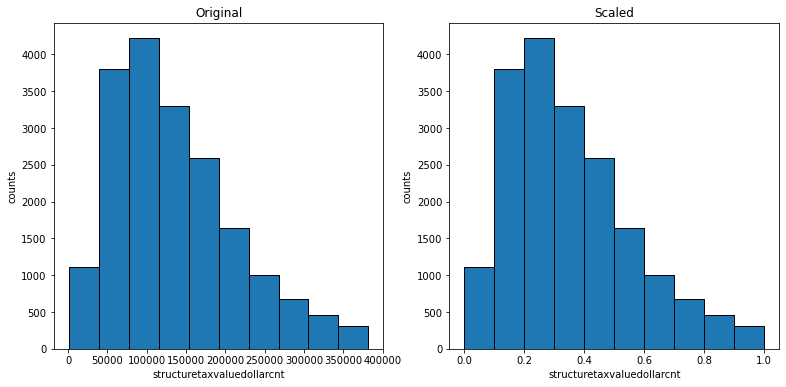

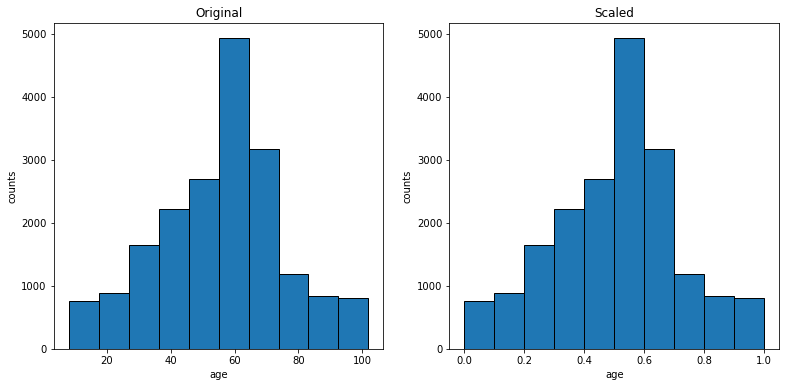

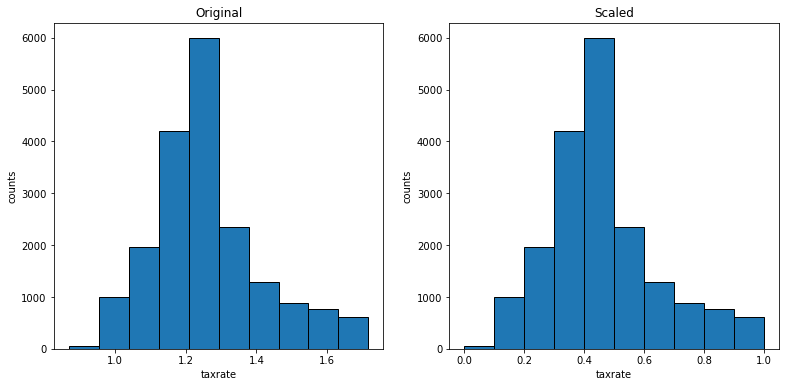

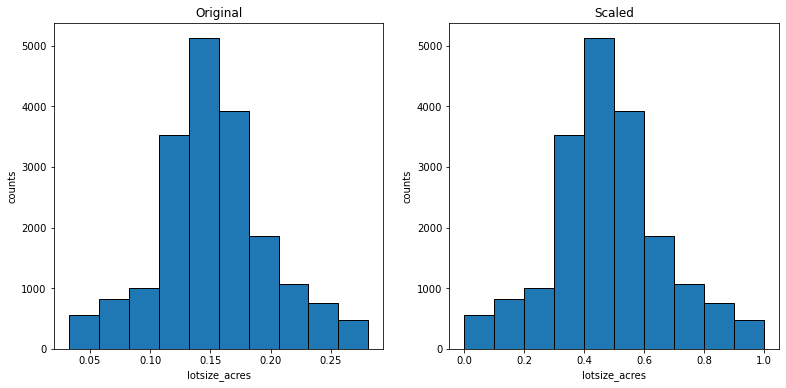

In [112]:
train_scaled_df, validate_scaled_df, test_scaled_df = p.scaled_df( train , validate, test, scal_var, MinMaxScaler())

In [113]:
train_scaled_df.head()

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
54155     0.333333    0.333333                      0.313487  0.613317   
44501     0.666667    0.333333                      0.870395  0.348033   
77435     0.000000    0.000000                      0.107237  0.421688   
43382     0.333333    0.666667                      0.436184  0.295367   
34022     0.333333    0.333333                      0.450987  0.478206   

       longitude  structuretaxvaluedollarcnt       age   taxrate  \
54155   0.502362                    0.241588  0.627660  0.399570   
44501   0.914765                    0.819619  0.180851  0.228981   
77435   0.563148                    0.176536  0.712766  0.408601   
43382   0.811214                    0.178186  0.595745  0.699603   
34022   0.816097                    0.370804  0.542553  0.491276   

       lotsize_acres  parcelid  ...  regionidzip  landtaxvaluedollarcnt  \
54155       0.603730  10820004  ...      96415.0               368100.0   
44501       0.479180  14204400  ...      97027.0               582701.0   
77435       0.415012  11468343  ...      96026.0                65798.0   
43382       0.541963  13934312  ...      97047.0                35498.0   
34022       0.488875  12837858  ...      96488.0                51930.0   

       logerror  transactiondate  county_name  la_cnty orange_cnty  \
54155 -0.028796         20170705  Los Angeles        1           0   
44501  0.003204         20170608       Orange        0           1   
77435  0.093275         20170919  Los Angeles        1           0   
43382 -0.010305         20170605       Orange        0           1   
34022 -0.027473         20170508  Los Angeles        1           0   

      ventura_cnty  quadrimester  logerror_bins  
54155            0             2  (-0.05, 0.05]  
44501            0             2  (-0.05, 0.05]  
77435            0             3    (0.05, 0.2]  
43382            0             2  (-0.05, 0.05]  
34022            0             2  (-0.05, 0.05]  

[5 rows x 23 columns]

In [10]:
train_scaled_df.head()


bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
54155     0.333333    0.333333                      0.313487  0.613317   
44501     0.666667    0.333333                      0.870395  0.348033   
77435     0.000000    0.000000                      0.107237  0.421688   
43382     0.333333    0.666667                      0.436184  0.295367   
34022     0.333333    0.333333                      0.450987  0.478206   

       longitude  structuretaxvaluedollarcnt       age   taxrate  \
54155   0.502362                    0.241588  0.627660  0.399570   
44501   0.914765                    0.819619  0.180851  0.228981   
77435   0.563148                    0.176536  0.712766  0.408601   
43382   0.811214                    0.178186  0.595745  0.699603   
34022   0.816097                    0.370804  0.542553  0.491276   

       lotsize_acres  parcelid  ...  regionidzip  landtaxvaluedollarcnt  \
54155       0.603730  10820004  ...      96415.0               368100.0   
44501       0.479180  14204400  ...      97027.0               582701.0   
77435       0.415012  11468343  ...      96026.0                65798.0   
43382       0.541963  13934312  ...      97047.0                35498.0   
34022       0.488875  12837858  ...      96488.0                51930.0   

       logerror  transactiondate  county_name  la_cnty orange_cnty  \
54155 -0.028796         20170705  Los Angeles        1           0   
44501  0.003204         20170608       Orange        0           1   
77435  0.093275         20170919  Los Angeles        1           0   
43382 -0.010305         20170605       Orange        0           1   
34022 -0.027473         20170508  Los Angeles        1           0   

      ventura_cnty  quadrimester  logerror_bins  
54155            0             2  (-0.05, 0.05]  
44501            0             2  (-0.05, 0.05]  
77435            0             3    (0.05, 0.2]  
43382            0             2  (-0.05, 0.05]  
34022            0             2  (-0.05, 0.05]  

[5 rows x 23 columns]

# Explore 

explore target

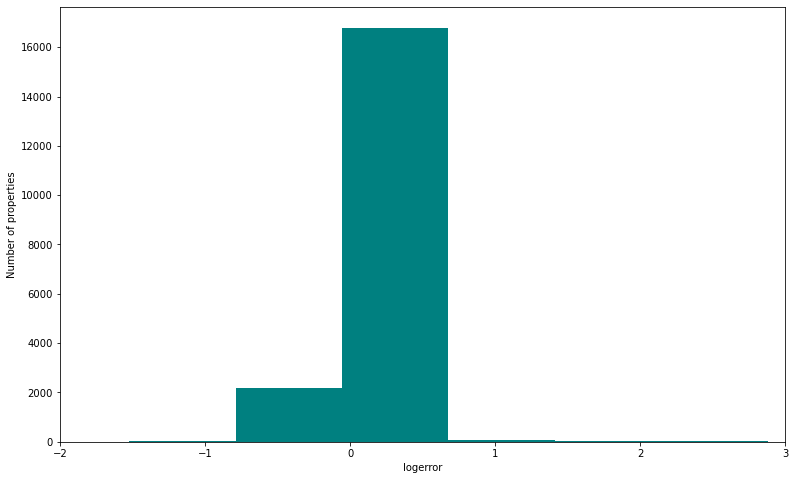

In [11]:
plt.figure(figsize=(13, 8))
train['logerror'].hist(grid=False, color = 'teal')
plt.xlabel("logerror")
plt.ylabel("Number of properties")                               
plt.xlim(-2 ,3)
plt.show()

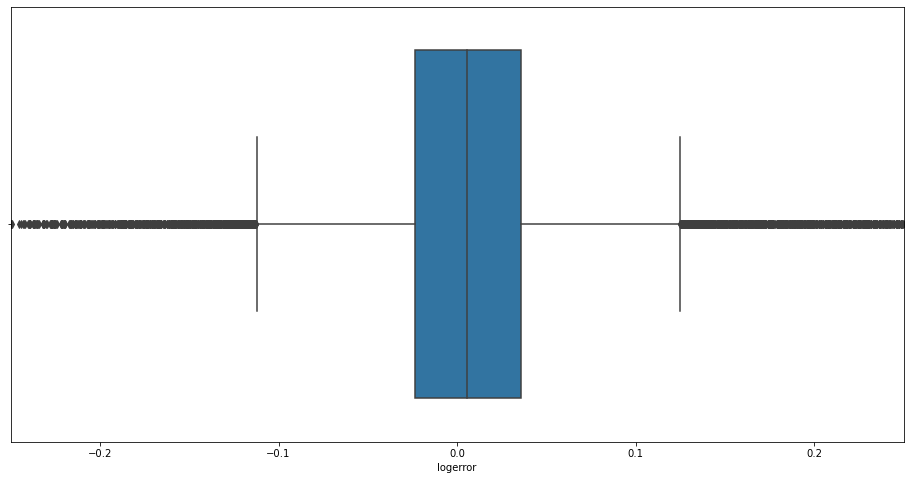

In [12]:
plt.figure(figsize=(16, 8))
sns.boxplot(train['logerror'])
plt.xlim(-.25 ,.25)
plt.show()

In [13]:
train['logerror'].describe()

count    19110.000000
mean         0.015705
std          0.156472
min         -4.453964
25%         -0.023494
50%          0.005676
75%          0.035816
max          2.876386
Name: logerror, dtype: float64

In [14]:
train.logerror_bins.value_counts()

(-0.05, 0.05]    13033
(0.05, 0.2]       2797
(-0.2, -0.05]     2201
(0.2, 4.0]         772
(-5.0, -0.2]       307
Name: logerror_bins, dtype: int64

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19110 entries, 54155 to 12794
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   parcelid                      19110 non-null  object  
 1   bathroomcnt                   19110 non-null  float64 
 2   bedroomcnt                    19110 non-null  float64 
 3   calculatedfinishedsquarefeet  19110 non-null  float64 
 4   latitude                      19110 non-null  float64 
 5   longitude                     19110 non-null  float64 
 6   propertylandusetypeid         19110 non-null  float64 
 7   regionidcity                  19110 non-null  float64 
 8   regionidcounty                19110 non-null  float64 
 9   regionidzip                   19110 non-null  float64 
 10  structuretaxvaluedollarcnt    19110 non-null  float64 
 11  landtaxvaluedollarcnt         19110 non-null  float64 
 12  logerror                      19110 non-nu

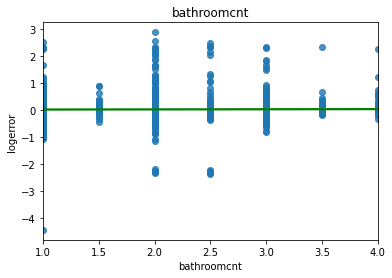

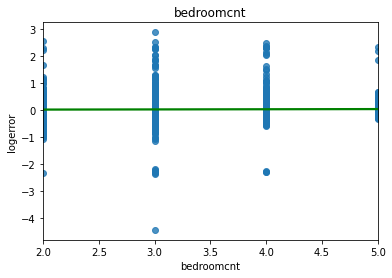

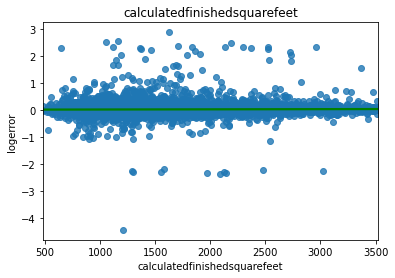

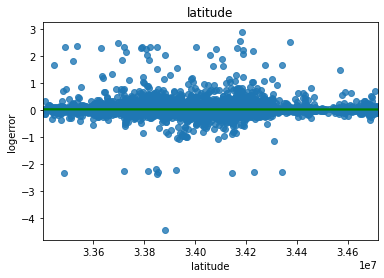

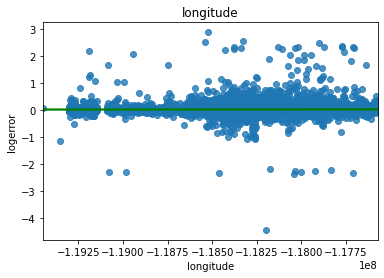

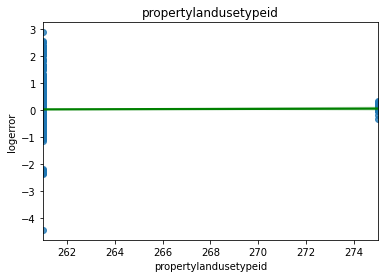

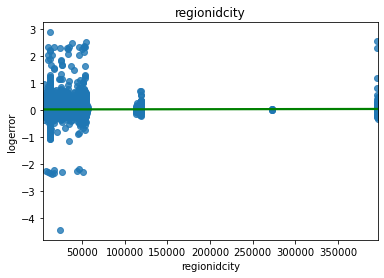

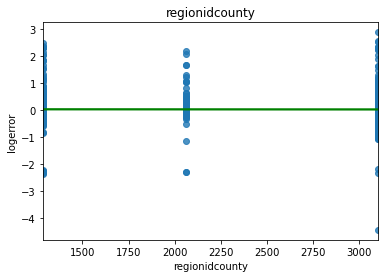

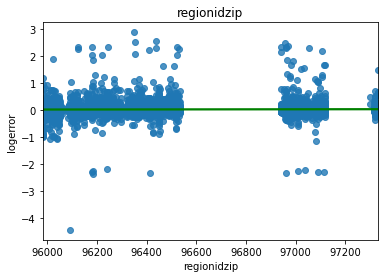

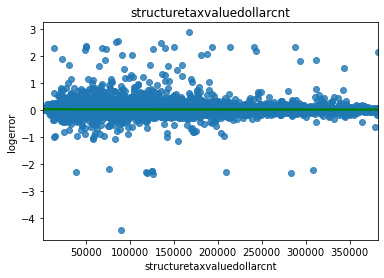

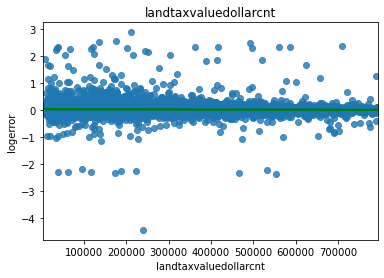

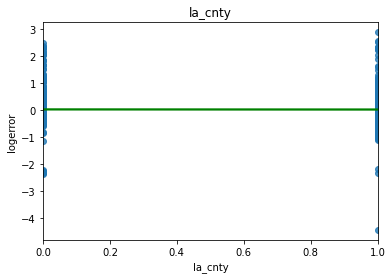

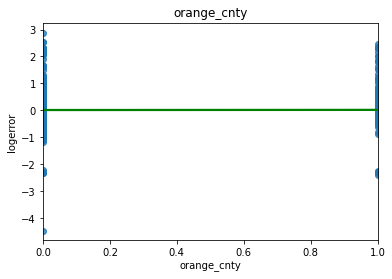

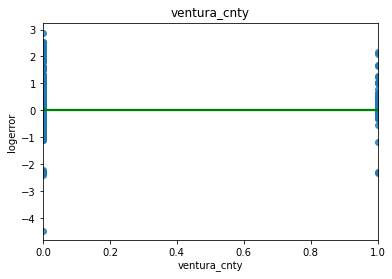

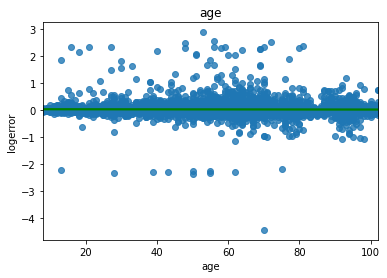

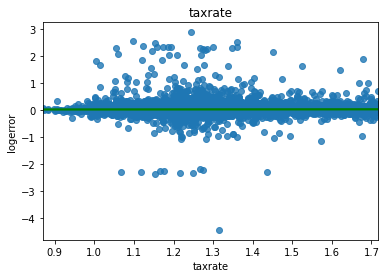

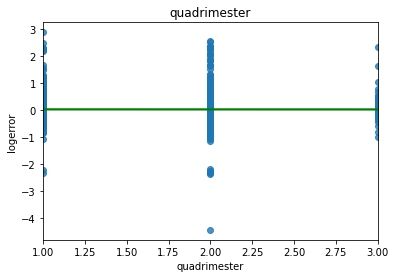

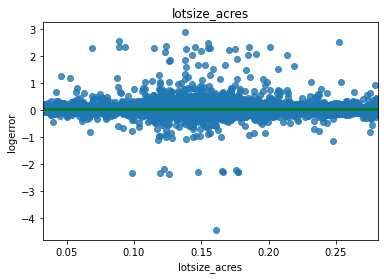

In [16]:
ex.plot_variable_pairs(train, 'logerror')

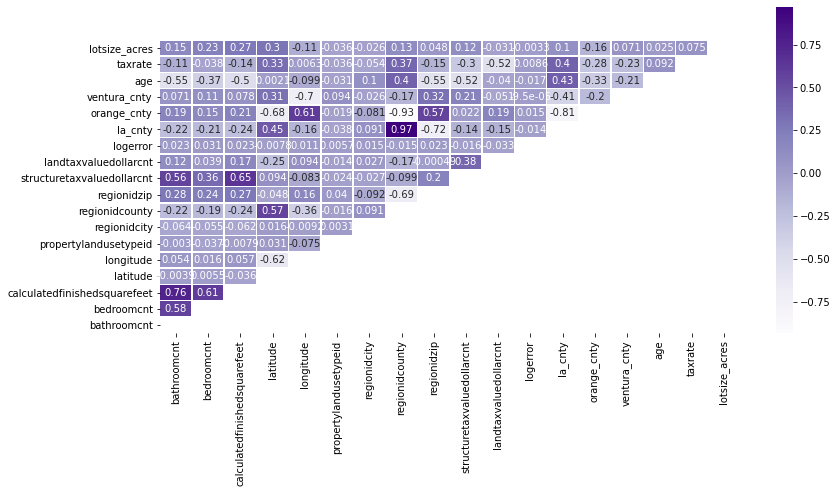

In [21]:
plt.figure(figsize=(13, 6))
ex.heatmap(train)

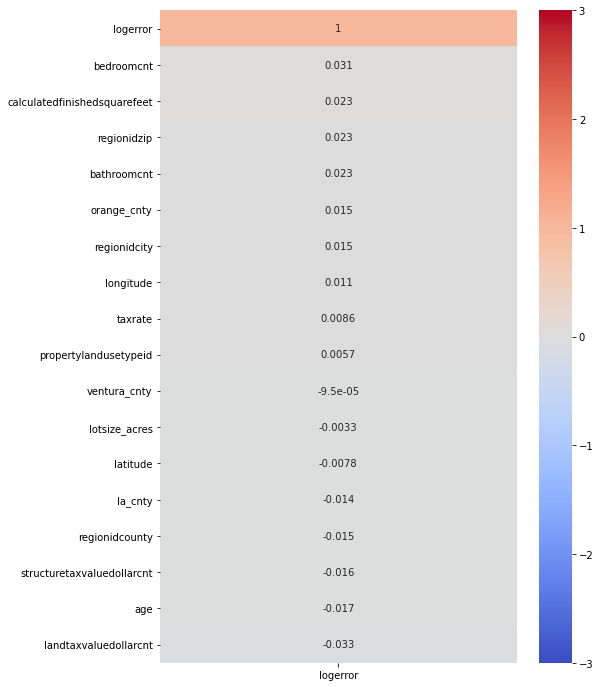

In [30]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr()[['logerror']].sort_values(by='logerror', ascending=False), vmin=-3, vmax=3, annot=True, cmap='coolwarm')

In [ ]:
**takeaways**
-logerror does not correlate well with any one feature
    - landtaxvaluedollarcnt is the highest
- Because of the lack of correlation, clustering is the next step.

In [31]:
train.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'latitude', 'longitude', 'propertylandusetypeid', 'regionidcity',
       'regionidcounty', 'regionidzip', 'structuretaxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'logerror', 'transactiondate', 'county_name',
       'la_cnty', 'orange_cnty', 'ventura_cnty', 'age', 'taxrate',
       'quadrimester', 'lotsize_acres', 'logerror_bins'],
      dtype='object')

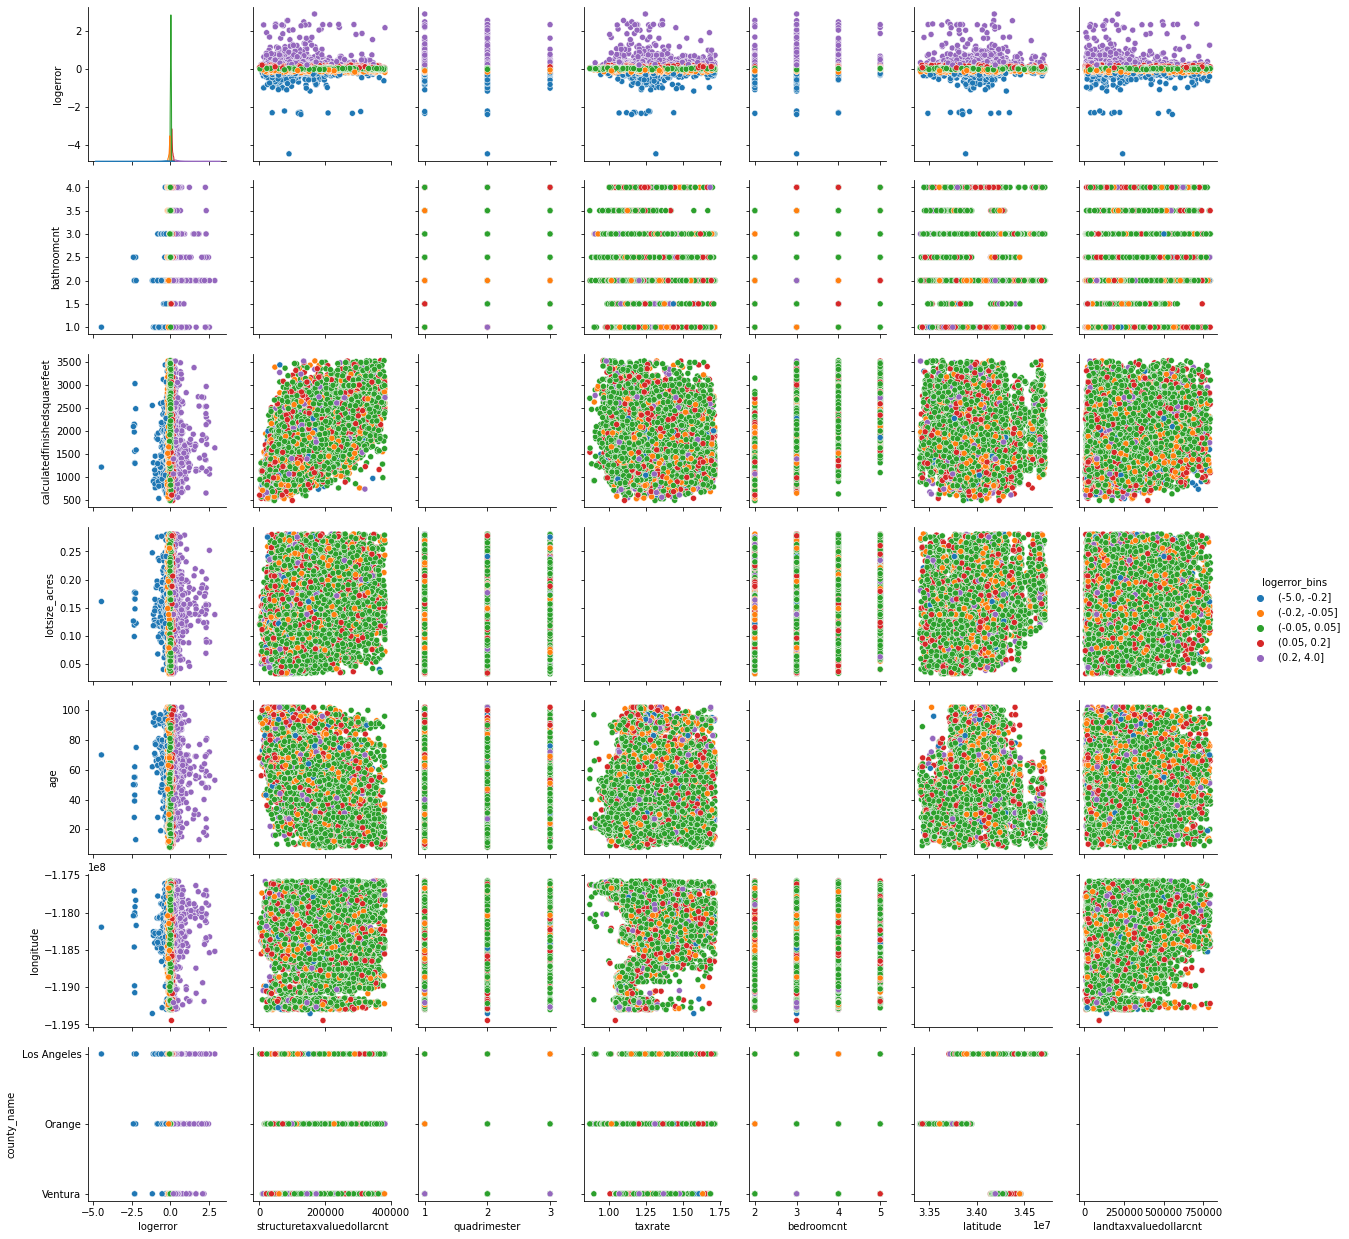

In [34]:
sns.pairplot(data = train, hue = 'logerror_bins',
             x_vars = ['logerror', 'structuretaxvaluedollarcnt', 'quadrimester', 'taxrate', 
                       'bedroomcnt','latitude','landtaxvaluedollarcnt'],
             y_vars = ['logerror', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'lotsize_acres', 'age', 'longitude', 'county_name'])

takeaways 
- the log error is low for the houses less than 20 years old  that were sold in the 2nd and 3rd quadrimester
- the range of log error is higher for the houses  that are 50 -70 years old
- the range of logerror is low for the lower and higher lot sizes
- the range of logerror is low for the lower and higher calculatedfinishedsqrefeet
- the logerror is low for the calculatedfihishedsquarefeet >1500 and with 4 bedrooms
- the logerror is low for 2.5 -3 bathrooms and were sold jan -dic
- the log error for a 5bedrooms is low with 1 -4 bathrooms except 2 bathrooms
- the range of log error in 3.5 baths is low
- 1st quadrimester  los angesles county has thwe less logerrror
- 2nd quadrimester (hot mohts) all three counties has less logerror
- 3rd quadrimester  Orange county has the less logerrror

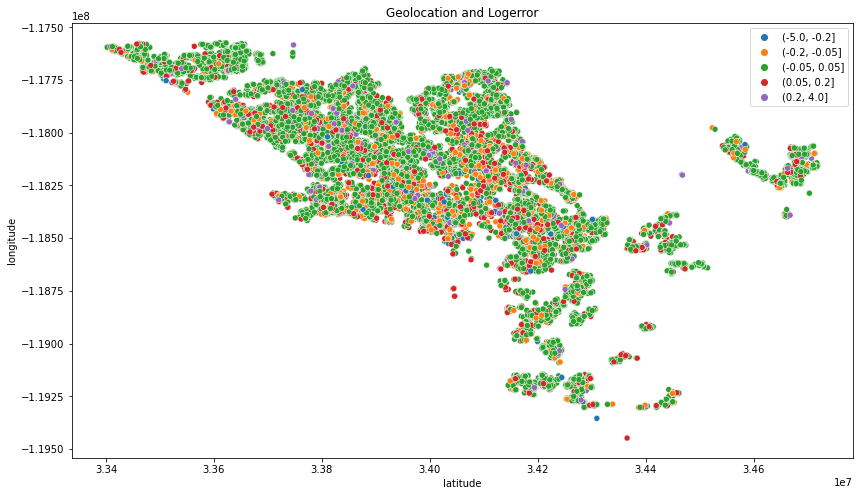

In [170]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='latitude', y='longitude', hue='logerror_bins', data=train)
plt.legend()
plt.title('Geolocation and Logerror')
plt.show()

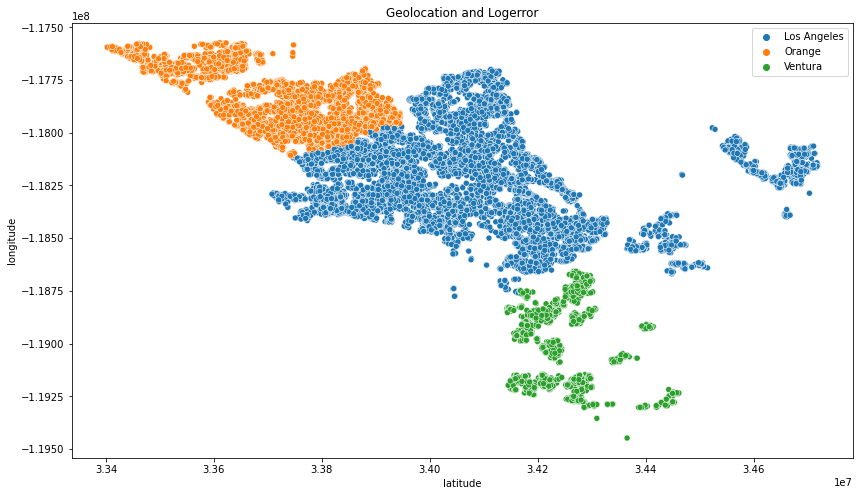

In [172]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='latitude', y='longitude', hue='county_name', data=train)
plt.legend()
plt.title('Geolocation and Logerror')
plt.show()

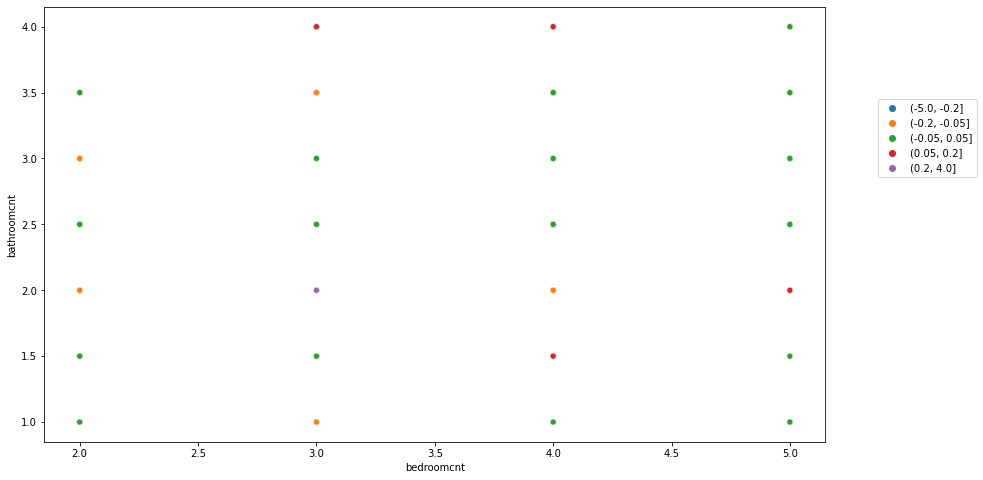

In [142]:
plt.figure(figsize=(14,8))
sns.scatterplot(x ='bedroomcnt', y = 'bathroomcnt', hue= 'logerror_bins', data = train)
plt.legend(bbox_to_anchor=(1.2,.8))

## Statistical Tests

In [ ]:
- T-test

### LA county vs Orange County

- 𝐻𝑜: there is no difference in average of logerror between  Los Angeles  and Orange Counties
- 𝐻𝑎 There is a signifficant average of logerror between  Los Angeles  and Orange Counties

1. Set Significance Level: $\alpha = .05$ (in other words Confidence level is 0.95)

2. Verify Assumptions:

    - Normal Distribution, or at least 30 observations and "kinda" normal. The more observations you have, the less "normal" it needs to appear. (CLT)
    - Independent samples
    - Equal Variances (or set method argument to False when not)
3. Compute test statistic and probability (t-statistic & p-value) using stats.ttest_ind

In [47]:

# Set Significance Level
alpha = 0.05

In [38]:
train.head()

parcelid  bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  \
54155  10820004          2.0         3.0                        1433.0   
44501  14204400          3.0         3.0                        3126.0   
77435  11468343          1.0         2.0                         806.0   
43382  13934312          2.0         4.0                        1806.0   
34022  12837858          2.0         3.0                        1851.0   

         latitude    longitude  propertylandusetypeid  regionidcity  \
54155  34209445.0 -118505975.0                  261.0       12447.0   
44501  33860307.0 -117732319.0                  261.0       16764.0   
77435  33957244.0 -118391943.0                  261.0       12447.0   
43382  33790993.0 -117926578.0                  261.0       24832.0   
34022  34031627.0 -117917417.0                  261.0      118694.0   

       regionidcounty  regionidzip  ...  transactiondate  county_name  \
54155          3101.0      96415.0  ...         20170705  Los Angeles   
44501          1286.0      97027.0  ...         20170608       Orange   
77435          3101.0      96026.0  ...         20170919  Los Angeles   
43382          1286.0      97047.0  ...         20170605       Orange   
34022          3101.0      96488.0  ...         20170508  Los Angeles   

       la_cnty orange_cnty ventura_cnty   age   taxrate  quadrimester  \
54155        1           0            0  67.0  1.208093             2   
44501        0           1            0  25.0  1.063828             2   
77435        1           0            0  75.0  1.215730             3   
43382        0           1            0  64.0  1.461827             2   
34022        1           0            0  59.0  1.285648             2   

       lotsize_acres  logerror_bins  
54155       0.182484  (-0.05, 0.05]  
44501       0.151515  (-0.05, 0.05]  
77435       0.135560    (0.05, 0.2]  
43382       0.167126  (-0.05, 0.05]  
34022       0.153926  (-0.05, 0.05]  

[5 rows x 23 columns]

In [39]:
#create my groups
la = train[train.la_cnty == 1].logerror
orange = train[train.orange_cnty ==1 ].logerror

In [40]:
#Normal Distribution
la.shape, orange.shape

((11911,), (5466,))

In [41]:
# Equal Variances (or set method argument to False when not)
la.var(), orange.var()

(0.023073818476484646, 0.027404083467743045)

In [44]:
#inequal variance

In [45]:
#Compute Test Statistic
t, p = stats.ttest_ind(la, orange, equal_var = False)
t,p

(-2.0871975888848446, 0.03689596855728124)

In [48]:
if (p < alpha):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


### landtaxvaluedollarcnt vs logerror

In [ ]:
- 𝐻𝑜: there is no linear relationship between  logerror and  landtaxvaluedollarcnt
- 𝐻𝑎: there is a linear relationship between  logerror and  landtaxvaluedollarcnt

**Pearson R**

In [51]:
r, p = stats.pearsonr(train['landtaxvaluedollarcnt'], train['logerror'])
r,p

(-0.03297829270878411, 5.119610685518519e-06)

In [50]:
if (p < alpha):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


###  Data exploration with Clusters

- **1st Clustering Combination: Clustering for bedrooms and bathrooms**

In [114]:
def create_cluster(df, X, k, name):
    
    """ Takes in df, X (dataframe with variables you want to cluster on) and k
    # It scales the X, calcuates the clusters and return train (with clusters), the Scaled dataframe,
    #the scaler and kmeans object and unscaled centroids as a dataframe"""
    
    scaler = StandardScaler(copy=True).fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(X_scaled)
    kmeans.predict(X_scaled)
    df[name] = kmeans.predict(X_scaled)
    df[name] = 'cluster_' + df[name].astype(str)
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    return df, X_scaled, scaler, kmeans, centroids

In [143]:
def create_scatter_plot(x,y,df,kmeans, X_scaled, scaler, name):
    
    """ Takes in x and y (variable names as strings, along with returned objects from previous
    function create_cluster and creates a plot"""
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x = x, y = y, data = df, hue = name)
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    centroids.plot.scatter(y=y, x= x, ax=plt.gca(), alpha=.30, s=500, c='black')
    plt.legend(bbox_to_anchor=(1.2,.8))

In [186]:
# What value of k is appropriate?

def scatter_plot_ks (X_df, X_scaled, x, y, start, finish):
    fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

    for ax, k in zip(axs.ravel(), range(start , finish)):
        clusters = KMeans(k).fit(X_scaled_df).predict(X_scaled_df)
        ax.scatter(X_df[x], X_df[y], c=clusters)
        ax.set(title='k = {}'.format(k), xlabel=x, ylabel=y)

In [117]:
# let's explore based on annual_income and spending score
def elbow_chart ( X, end_range):
    scaler = StandardScaler().fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

    
    # let is explore what values of k might be appropriate
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(9, 6))
        pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, end_range)}).plot(marker='x')
        plt.xticks(range(2, end_range))
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Change in inertia as k increases')

- **1st Clustering Combination: Clustering for age and bathrooms**

In [118]:
X = X_train[['age', 'bedroomcnt']]

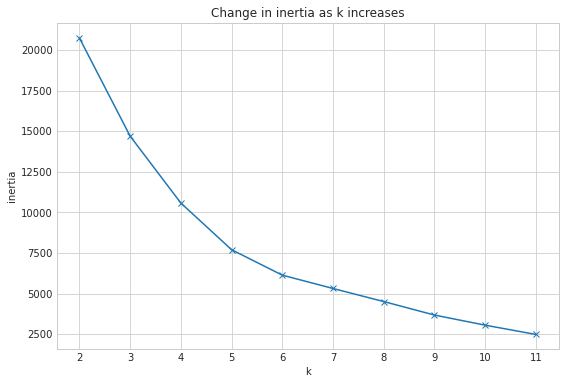

In [119]:
elbow_chart (X , 12)

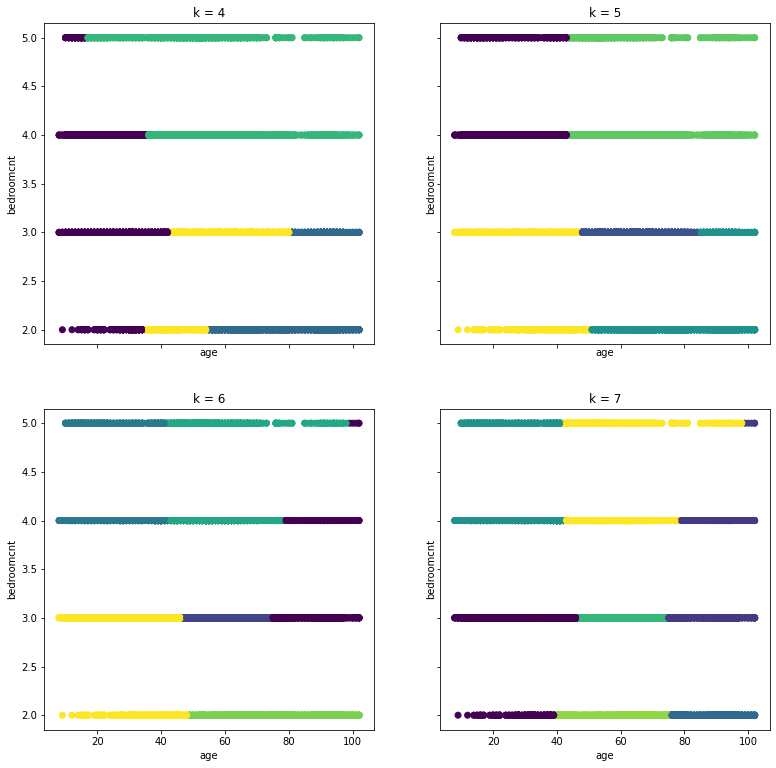

In [153]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(4, 9)):
    clusters = KMeans(k).fit(X_scaled).predict(X_scaled)
    ax.scatter(X_train.age, X_train.bedroomcnt, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='age', ylabel='bedroomcnt')

In [144]:
df, X_scaled, scaler, kmeans, centroids = create_cluster(X_train,X , 5 , 'cluster_age_bed')

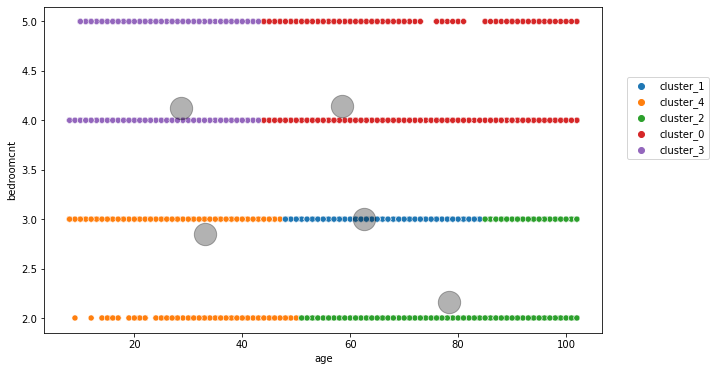

In [145]:
 create_scatter_plot('age','bedroomcnt',df,kmeans, X_scaled, scaler, 'cluster_age_bed')


- 2nd Clustering Combination: longitude  and latitude

In [162]:
X = X_train[['latitude', 'longitude', '']]

In [163]:
X.head()

latitude    longitude
54155  34209445.0 -118505975.0
44501  33860307.0 -117732319.0
77435  33957244.0 -118391943.0
43382  33790993.0 -117926578.0
34022  34031627.0 -117917417.0

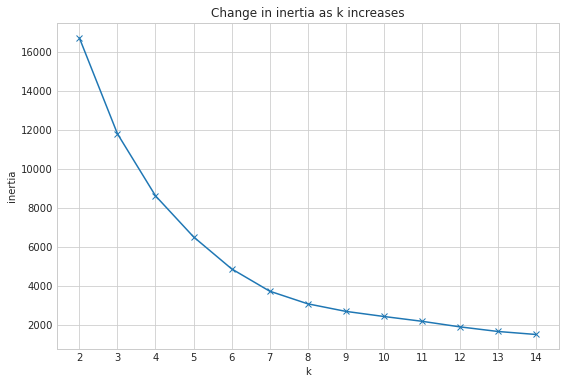

In [165]:
elbow_chart (X , 15)

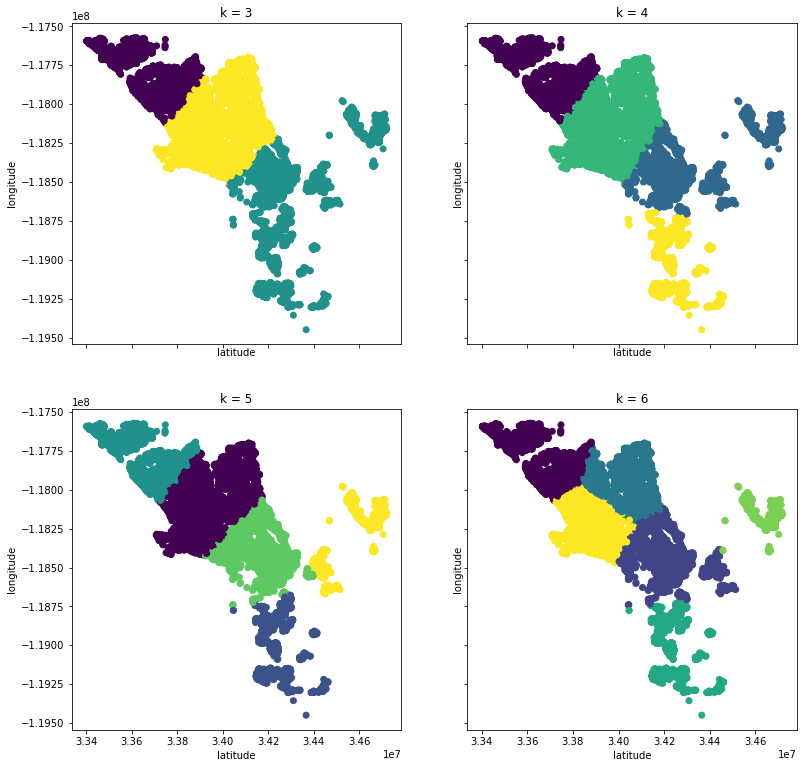

In [169]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(3, 7)):
    clusters = KMeans(k).fit(X_scaled).predict(X_scaled)
    ax.scatter(X_train.latitude, X_train.longitude, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='latitude', ylabel='longitude')

In [175]:
df, X_scaled, scaler, kmeans, centroids = create_cluster(X_train,X ,4 , 'cluster_lat_long')

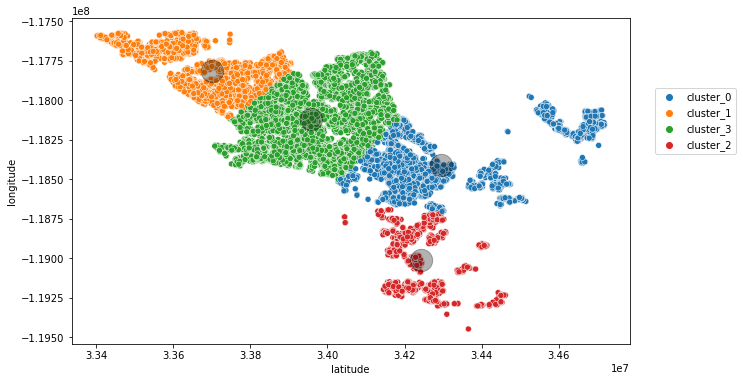

In [176]:
 create_scatter_plot('latitude','longitude',df,kmeans, X_scaled, scaler, 'cluster_lat_long')

In [177]:
X_train.head()

parcelid  bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  \
54155  10820004          2.0         3.0                        1433.0   
44501  14204400          3.0         3.0                        3126.0   
77435  11468343          1.0         2.0                         806.0   
43382  13934312          2.0         4.0                        1806.0   
34022  12837858          2.0         3.0                        1851.0   

         latitude    longitude  propertylandusetypeid  regionidcity  \
54155  34209445.0 -118505975.0                  261.0       12447.0   
44501  33860307.0 -117732319.0                  261.0       16764.0   
77435  33957244.0 -118391943.0                  261.0       12447.0   
43382  33790993.0 -117926578.0                  261.0       24832.0   
34022  34031627.0 -117917417.0                  261.0      118694.0   

       regionidcounty  regionidzip  ...   age   taxrate quadrimester  \
54155          3101.0      96415.0  ...  67.0  1.208093            2   
44501          1286.0      97027.0  ...  25.0  1.063828            2   
77435          3101.0      96026.0  ...  75.0  1.215730            3   
43382          1286.0      97047.0  ...  64.0  1.461827            2   
34022          3101.0      96488.0  ...  59.0  1.285648            2   

      lotsize_acres  logerror_bins  cluster_age_bed  cluster_age_bed5  \
54155      0.182484  (-0.05, 0.05]        cluster_1         cluster_1   
44501      0.151515  (-0.05, 0.05]        cluster_4         cluster_4   
77435      0.135560    (0.05, 0.2]        cluster_2         cluster_2   
43382      0.167126  (-0.05, 0.05]        cluster_0         cluster_0   
34022      0.153926  (-0.05, 0.05]        cluster_1         cluster_1   

       cluster_age_bed7  cluster_age_bed6 cluster_lat_long  
54155         cluster_1         cluster_5        cluster_0  
44501         cluster_4         cluster_4        cluster_1  
77435         cluster_2         cluster_2        cluster_3  
43382         cluster_0         cluster_3        cluster_1  
34022         cluster_1         cluster_5        cluster_3  

[5 rows x 27 columns]

-  Clustering Combination: lotsize_acres vs calculatedfinishedsquarefeet

In [183]:
X = X_train[['lotsize_acres', 'calculatedfinishedsquarefeet']]

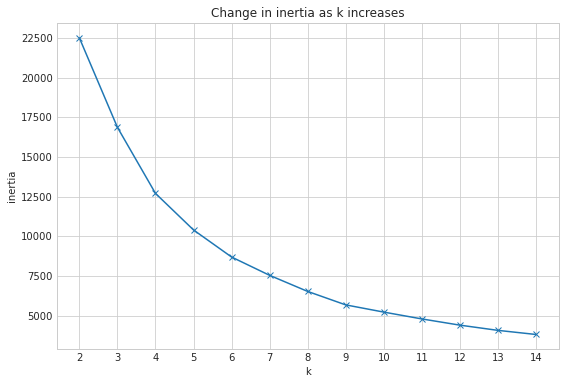

In [184]:
elbow_chart (X , 15)

In [191]:
df, X_scaled, scaler, kmeans, centroids = create_cluster(X_train,X ,4 , 'cluster_lot_finish')

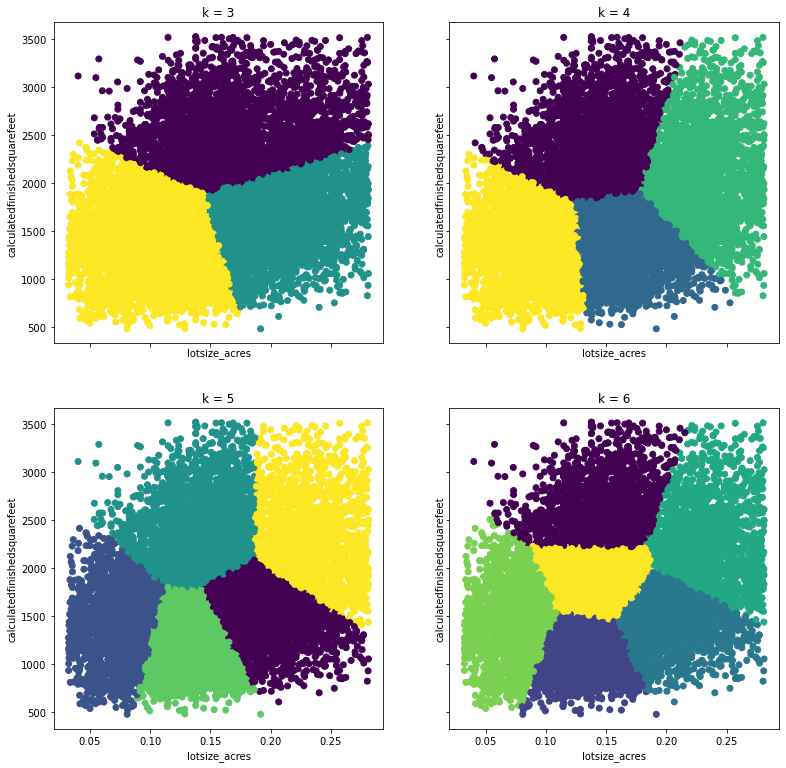

In [192]:
scatter_plot_ks (X_train, X_scaled, 'lotsize_acres','calculatedfinishedsquarefeet', 3, 7)

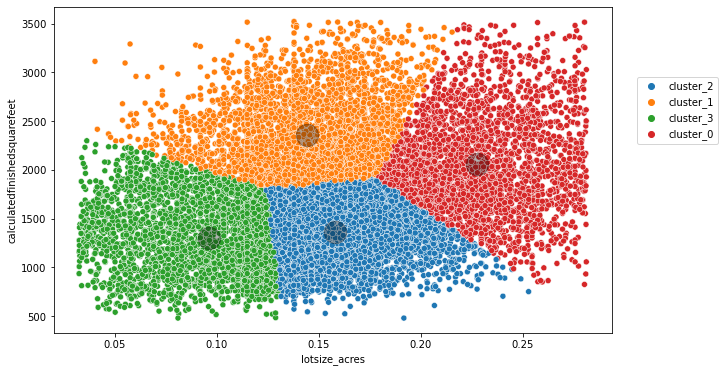

In [190]:
create_scatter_plot('lotsize_acres','calculatedfinishedsquarefeet',df,kmeans, X_scaled, scaler, 'cluster_lot_finish')

In [193]:
X_train.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'latitude', 'longitude', 'propertylandusetypeid', 'regionidcity',
       'regionidcounty', 'regionidzip', 'structuretaxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'transactiondate', 'county_name', 'la_cnty',
       'orange_cnty', 'ventura_cnty', 'age', 'taxrate', 'quadrimester',
       'lotsize_acres', 'logerror_bins', 'cluster_age_bed', 'cluster_age_bed5',
       'cluster_age_bed7', 'cluster_age_bed6', 'cluster_lat_long',
       'cluster_lot_finish'],
      dtype='object')

In [ ]:
Clustering Combination: quadrimester vs county_name

In [196]:
X = X_train[['quadrimester', 'regionidzip']]

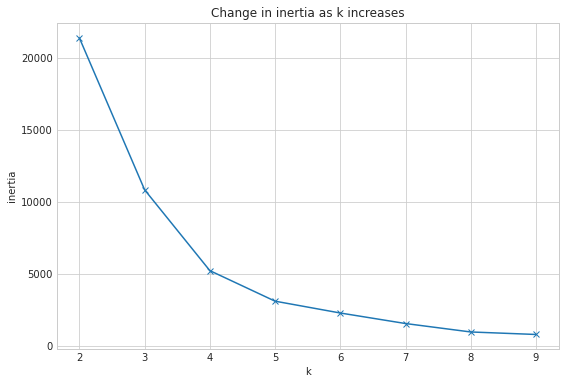

In [198]:
elbow_chart (X , 10)

In [200]:
df, X_scaled, scaler, kmeans, centroids = create_cluster(X_train,X ,4 , 'cluster_quadrimester_zipcode')

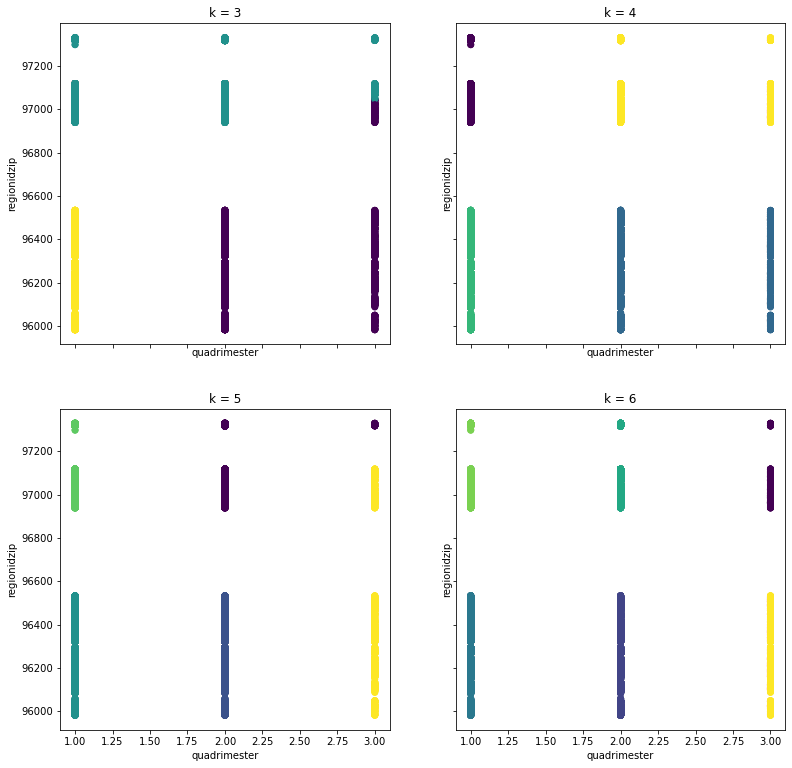

In [201]:
scatter_plot_ks (X_train, X_scaled, 'quadrimester','regionidzip', 3, 7)

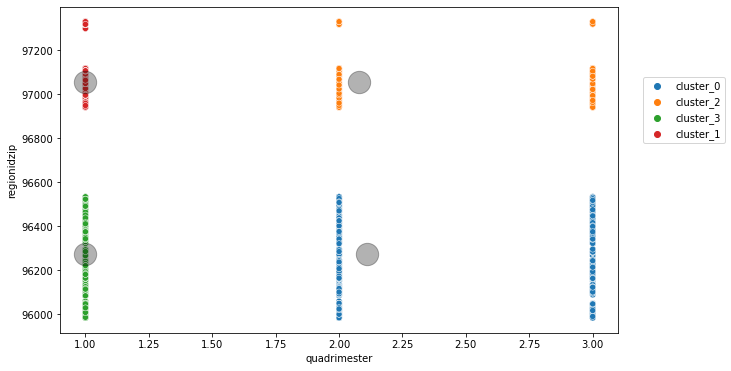

In [202]:
create_scatter_plot('quadrimester','regionidzip',df,kmeans, X_scaled, scaler, 'cluster_quadrimester_zipcode')

'age', 'calculatedfinishedsquarefeet'

In [217]:
X = X_train[['age', 'calculatedfinishedsquarefeet']]

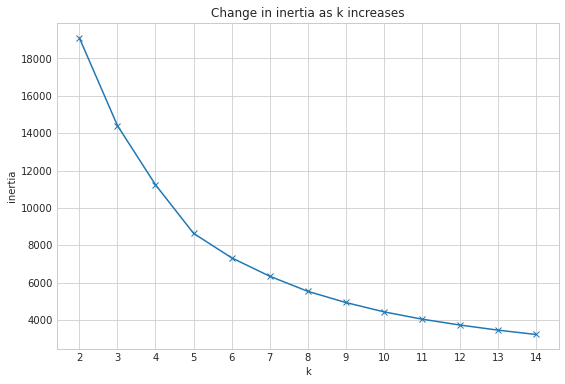

In [218]:
elbow_chart (X , 15)

In [219]:
df, X_scaled, scaler, kmeans, centroids = create_cluster(X_train,X ,5 , 'cluster_age_sqft')

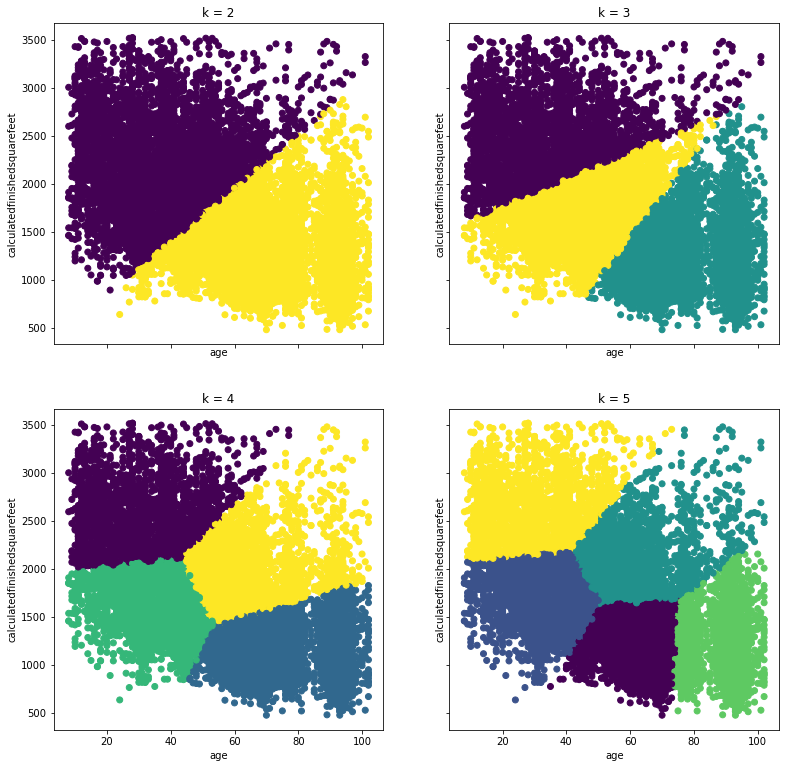

In [220]:
scatter_plot_ks (X_train, X_scaled, 'age', 'calculatedfinishedsquarefeet', 2, 7)

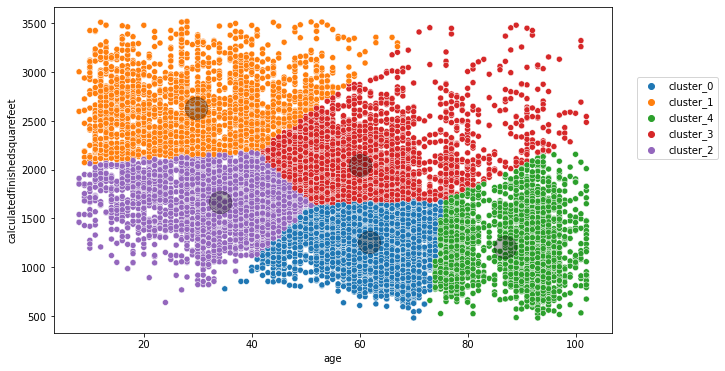

In [223]:
create_scatter_plot('age', 'calculatedfinishedsquarefeet',df,kmeans, X_scaled, scaler, 'cluster_age_sqft')

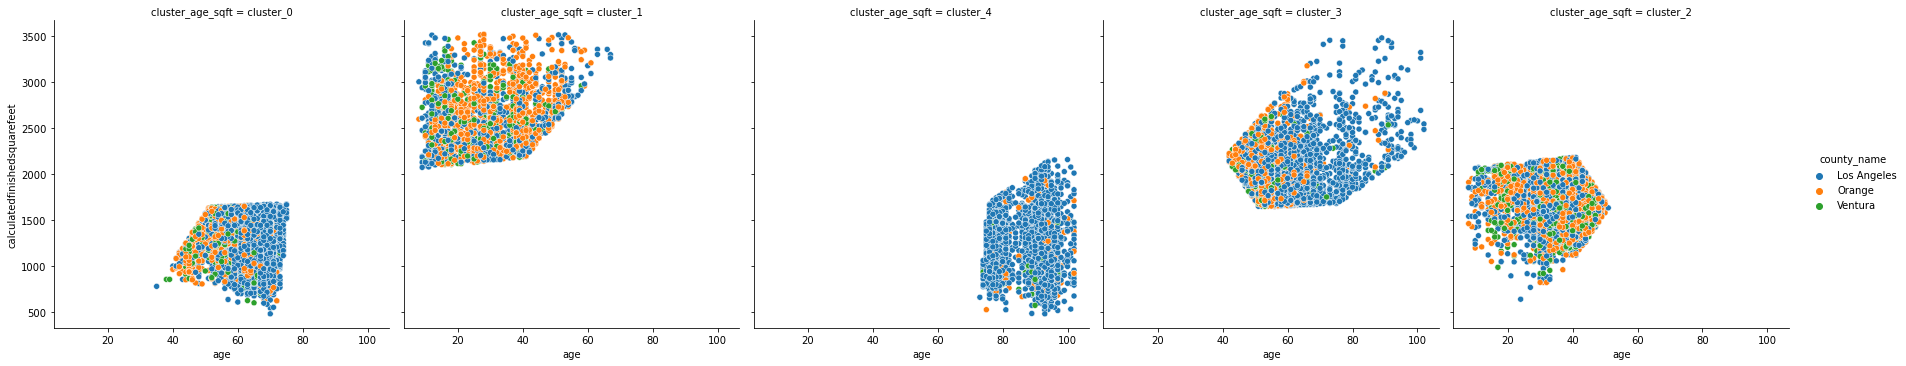

In [228]:
sns.relplot(x = 'age', y = 'calculatedfinishedsquarefeet', data = df, col = 'cluster_age_sqft', hue = 'county_name')

# Modeling

In [224]:
#conver y_train y _ validate to df
y_train = pd.DataFrame( {'actual': y_train})
y_validate = pd.DataFrame( {'actual': y_validate})
y_test = pd.DataFrame( {'actual': y_test})